Solve the hydro-thermal power system planning problem: TS approach
=====================================================

The TS approach addes additional four state variables to transform the Markovian problem into stage-wise independent.

In [1]:
import pandas
import numpy
import gurobipy
from msppy.msp import MSLP
from msppy.solver import SDDP
from msppy.evaluation import Evaluation,EvaluationTrue
import sys
import seaborn
seaborn.set_style('darkgrid')

gamma = numpy.array(pandas.read_csv(
    "./data/gamma.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
sigma = [
    numpy.array(pandas.read_csv(
        "./data/sigma_{}.csv".format(i),
        names=[0,1,2,3],
        index_col=0,
        skiprows=1,
    )) for i in range(12)
]
exp_mu = numpy.array(pandas.read_csv(
    "./data/exp_mu.csv",
    names=[0,1,2,3],
    index_col=0,
    skiprows=1,
))
hydro_ = pandas.read_csv("./data/hydro.csv", index_col=0)
demand = pandas.read_csv("./data/demand.csv", index_col=0)
deficit_ = pandas.read_csv("./data/deficit.csv", index_col=0)
exchange_ub = pandas.read_csv("./data/exchange.csv", index_col=0)
exchange_cost = pandas.read_csv("./data/exchange_cost.csv", index_col=0)
thermal_ = [pandas.read_csv("./data/thermal_{}.csv".format(i),
    index_col=0) for i in range(4)]
stored_initial = hydro_['INITIAL'][:4]
inflow_initial = hydro_['INITIAL'][4:8]

def sampler(t):
    def inner(random_state):
        noise = numpy.exp(
            random_state.multivariate_normal(mean=[0]*4, cov=sigma[t%12]))
        coef = [None]*4
        rhs = [None]*4
        for i in range(4):
            coef[i] = -noise[i]*gamma[t%12][i]*exp_mu[t%12][i]/exp_mu[(t-1)%12][i]
            rhs[i] = noise[i]*(1-gamma[t%12][i])*exp_mu[t%12][i]
        return (coef+rhs)
    return inner

T = 120
HydroThermal = MSLP(T=T, bound=0, discount=0.9906)
for t in range(T):
    m = HydroThermal[t]
    stored_now,stored_past = m.addStateVars(4, ub=hydro_['UB'][:4], name="stored")
    inflow_now,inflow_past = m.addStateVars(4, name="inflow")
    spill = m.addVars(4, obj=0.001, name="spill")
    hydro = m.addVars(4, ub=hydro_['UB'][-4:], name="hydro")
    deficit = m.addVars(
        [(i,j) for i in range(4) for j in range(4)],
        ub = [
            demand.iloc[t%12][i] * deficit_['DEPTH'][j]
            for i in range(4) for j in range(4)
        ],
        obj = [
            deficit_['OBJ'][j]
            for i in range(4) for j in range(4)
        ],
        name = "deficit")
    thermal = [None] * 4
    for i in range(4):
        thermal[i] = m.addVars(
            len(thermal_[i]),
            ub=thermal_[i]['UB'],
            lb=thermal_[i]['LB'],
            obj=thermal_[i]['OBJ'],
            name="thermal_{}".format(i)
        )
    exchange = m.addVars(5,5, obj=exchange_cost.values.flatten(),
        ub=exchange_ub.values.flatten(), name="exchange")
    thermal_sum = m.addVars(4, name="thermal_sum")
    m.addConstrs(thermal_sum[i] ==
        gurobipy.quicksum(thermal[i].values()) for i in range(4))
    for i in range(4):
        m.addConstr(
            thermal_sum[i]
            + gurobipy.quicksum(deficit[(i,j)] for j in range(4))
            + hydro[i]
            - gurobipy.quicksum(exchange[(i,j)] for j in range(5))
            + gurobipy.quicksum(exchange[(j,i)] for j in range(5))
            == demand.iloc[t%12][i]
        )
    m.addConstr(
        gurobipy.quicksum(exchange[(j,4)] for j in range(5))
        - gurobipy.quicksum(exchange[(4,j)] for j in range(5))
        == 0
    )
    m.addConstrs(
        stored_now[i] + spill[i] + hydro[i] - stored_past[i] == inflow_now[i]
        for i in range(4)
    )
    if t == 0:
        m.addConstrs(stored_past[i] == stored_initial[i] for i in range(4))
        m.addConstrs(inflow_now[i] == inflow_initial[i] for i in range(4))
    else:
        TS = m.addConstrs(inflow_now[i] + inflow_past[i] == 0 for i in range(4))
        m.add_continuous_uncertainty(
            uncertainty=sampler(t),
            locations=(
                [(TS[i],inflow_past[i]) for i in range(4)]
                + [TS[i] for i in range(4)]
            ),
        )
HydroThermal.discretize(n_samples=100, random_state=888)
HT_sddp = SDDP(HydroThermal)
HT_sddp.solve(max_iterations=30, logToConsole=0)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

Academic license - for non-commercial use only


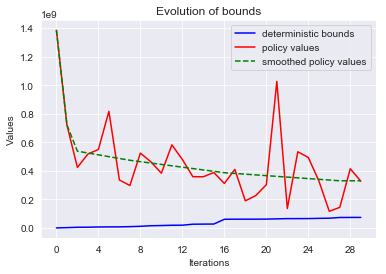

In [2]:
HT_sddp.plot_bounds(smooth=1);

In [3]:
result = Evaluation(HydroThermal)
result.run(n_simulations=100)
resultTrue = EvaluationTrue(HydroThermal)
resultTrue.run(n_simulations=100)

In [4]:
result.gap, result.CI

(4.450703665393967, (334803659.8013792, 404736434.96869767))

In [5]:
resultTrue.CI

(354235936.2711504, 439574590.54545575)